In [494]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
# import torch_summary as summary

In [495]:
import numpy as np
import plotly.graph_objects as go
import torch


def plot_model_learning(
        model, x, y, x_range=[-3, 3], y_range=[-150, 150], dx=1, dy=30
):
    """
    Visualize a dataset and the model's predictions, showing how the model fits the dataset.

    Parameters:
        model: Trained PyTorch model to generate predictions
        x: Input data (numpy array or torch tensor)
        y: True target values (numpy array or torch tensor)
        x_range: x-axis range [min, max] (default: [-3, 3])
        y_range: y-axis range [min, max] (default: [-150, 150])
        dx: Tick interval for x-axis
        dy: Tick interval for y-axis
    Returns:
        fig: A Plotly interactive figure
    """

    # Ensure `x` and `y` are numpy arrays for plotting
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.detach().numpy()

    # Generate predictions from the model
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_hat = model(x_tensor).detach().numpy()

    # Create the plot
    fig = go.Figure()

    # Plot the true data points
    fig.add_trace(
        go.Scatter(x=x.flatten(), y=y.flatten(), mode="markers",
                   marker=dict(size=10, color="blue"),
                   name="True Data")
    )

    # Plot the model's predictions
    fig.add_trace(
        go.Scatter(
            x=x.flatten(),
            y=y_hat.flatten(),
            mode="lines",
            line=dict(width=3, color="red"),
            name="Model Prediction",
        )
    )

    # Customize layout
    fig.update_layout(
        width=600,
        height=500,
        title="Model Learning Visualization",
        title_x=0.5,
        xaxis_title="Input (x)",
        yaxis_title="Output (y)",
        margin=dict(t=60),
    )
    fig.update_xaxes(range=x_range, tick0=x_range[0], dtick=dx)
    fig.update_yaxes(range=y_range, tick0=y_range[0], dtick=dy)

    return fig



def plot_dataset(x, y, x_range=None, y_range=None, dx=1, dy=30):
    """
    Plot a dataset (x, y) without any predictions.

    Parameters:
        x: Input data (numpy array or torch tensor).
        y: Output/target values (numpy array or torch tensor).
        x_range: x-axis range [min, max]. If None, it adapts automatically.
        y_range: y-axis range [min, max]. If None, it adapts automatically.
        dx: Tick interval for x-axis.
        dy: Tick interval for y-axis.
    Returns:
        fig: A Plotly interactive figure.
    """
    # Ensure `x` and `y` are numpy arrays for easier plotting
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.detach().numpy()

    # Create the plot
    fig = go.Figure()

    # Add data points as a scatter plot
    fig.add_trace(
        go.Scatter(
            x=x.flatten(),
            y=y.flatten(),
            mode="markers",
            marker=dict(size=10, color="blue"),
            name="Data Points"
        )
    )

    # Customize layout
    fig.update_layout(
        width=600,
        height=500,
        title="Dataset Scatter Plot",
        title_x=0.5,
        xaxis_title="Input (x)",
        yaxis_title="Output (y)",
        margin=dict(t=60),
    )

    # Set axis ranges if provided; otherwise, let Plotly auto-scale
    if x_range is not None:
        fig.update_xaxes(range=x_range, tick0=x_range[0], dtick=dx)
    if y_range is not None:
        fig.update_yaxes(range=y_range, tick0=y_range[0], dtick=dy)

    return fig



In [496]:
np.random.seed(42)

steps = np.random.randint(1000, 20000, 1000)
calories_burned = np.random.uniform(1200, 4500, 1000)
sleep_hours = np.random.uniform(4, 12, 1000)

health_score = (
    0.3 * (steps / 20000) * 100 +
    0.4 * ((calories_burned - 1200) / (4500 - 1200)) * 100 +
    0.3 * (sleep_hours / 12) * 100
)

health_score += np.random.normal(0, 5, 1000)

df = pd.DataFrame({
    'steps': steps,
    'calories_burned': calories_burned,
    'sleep_hours': sleep_hours,
    'health_score': health_score
})

print(df.corr())

df.head()

                    steps  calories_burned  sleep_hours  health_score
steps            1.000000        -0.049403    -0.058327      0.450064
calories_burned -0.049403         1.000000     0.023884      0.721397
sleep_hours     -0.058327         0.023884     1.000000      0.360569
health_score     0.450064         0.721397     0.360569      1.000000


,steps,calories_burned,sleep_hours,health_score
0,16795,2546.348835,8.895524,60.469143
1,1860,3020.684564,4.847446,33.014047
2,6390,2037.832261,5.212555,36.502435
3,12964,1847.173229,4.750055,31.040483
4,12284,2868.176001,8.617382,60.650668


In [497]:
X = df.drop('health_score', axis=1)
y = df['health_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [498]:
scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

X_train_tensor

tensor([[ 0.4044,  0.4760,  0.8436],
        [ 0.0682,  1.7618, -0.9887],
        [-0.1995,  1.3446,  0.2374],
        ...,
        [-0.7099, -0.4851,  0.4493],
        [ 1.2707,  0.3790,  0.5559],
        [-1.6231, -1.1941, -0.1826]])

In [499]:
import pandas as pd

correlation_matrix = pd.DataFrame(X_train, columns=['steps', 'calories_burned', 'sleep_hours'])
correlation_matrix['health_score'] = y_train.values

print(correlation_matrix.corr())

                    steps  calories_burned  sleep_hours  health_score
steps            1.000000        -0.065849    -0.076856      0.447322
calories_burned -0.065849         1.000000     0.034754      0.713229
sleep_hours     -0.076856         0.034754     1.000000      0.360362
health_score     0.447322         0.713229     0.360362      1.000000


In [500]:
class HealthDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = HealthDataset(X_train_tensor, y_train_tensor)
test_dataset = HealthDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [501]:
import torch.nn as nn

class HealthScoreNN(nn.Module):
    def __init__(self, input_size):
        super(HealthScoreNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.fc(x)

model = HealthScoreNN(input_size=3)

# for name, param in model.named_parameters():
#     print(f"Parameter name: {name}, Shape: {param.shape}")


In [502]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [503]:
epochs = 100
epoch_loss = []

for epoch in range(epochs):
    model.train()
    train_loss = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    avg_train_loss = sum(train_loss) / len(train_loader)
    epoch_loss.append(avg_train_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

Epoch 1/100, Train Loss: 3260.4301
Epoch 2/100, Train Loss: 3178.6766
Epoch 3/100, Train Loss: 2912.4034
Epoch 4/100, Train Loss: 2207.1711
Epoch 5/100, Train Loss: 995.9270
Epoch 6/100, Train Loss: 127.3984
Epoch 7/100, Train Loss: 29.6466
Epoch 8/100, Train Loss: 25.6790
Epoch 9/100, Train Loss: 25.3789
Epoch 10/100, Train Loss: 25.4061
Epoch 11/100, Train Loss: 25.4509
Epoch 12/100, Train Loss: 25.3969
Epoch 13/100, Train Loss: 25.4141
Epoch 14/100, Train Loss: 25.4654
Epoch 15/100, Train Loss: 25.5279
Epoch 16/100, Train Loss: 25.4534
Epoch 17/100, Train Loss: 25.4220
Epoch 18/100, Train Loss: 25.4165
Epoch 19/100, Train Loss: 25.4422
Epoch 20/100, Train Loss: 25.3682
Epoch 21/100, Train Loss: 25.3776
Epoch 22/100, Train Loss: 25.3920
Epoch 23/100, Train Loss: 25.4532
Epoch 24/100, Train Loss: 25.5914
Epoch 25/100, Train Loss: 25.6521
Epoch 26/100, Train Loss: 25.5718
Epoch 27/100, Train Loss: 25.4068
Epoch 28/100, Train Loss: 25.4080
Epoch 29/100, Train Loss: 25.4103
Epoch 30/100,

In [504]:
# plot_model_learning(model, X_train_tensor, y_train_tensor)


In [505]:
model.eval()

test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 34.9637


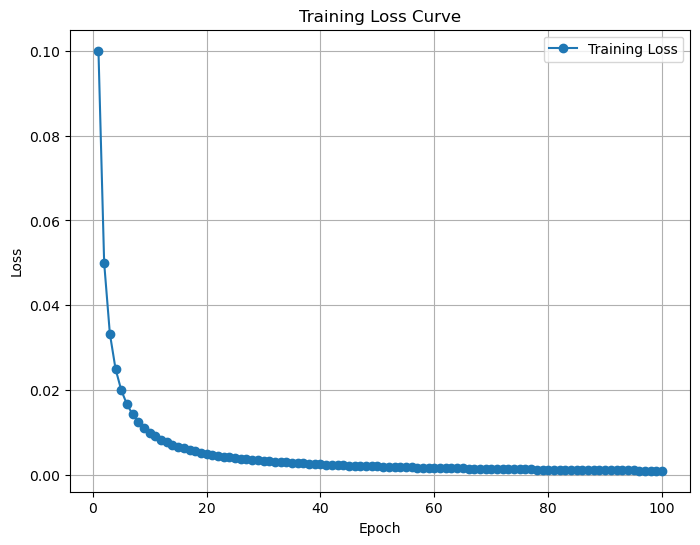

In [506]:
epochs = 100  # Number of epochs
train_loss = [0.1 / (epoch + 1) for epoch in range(epochs)]  # Simulated training loss values

# Correct plotting
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_loss, marker='o', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [507]:
from sklearn.metrics import r2_score

# Predict on the entire test set and calculate R2
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")


R² Score: 0.8965
